In [228]:
import os
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
import shap

In [85]:
rcParams['font.family']='Times New Roman'

In [236]:
tb = pd.read_csv('./results/all_features.csv')
tb

,1D Gray Entropy,2D Gray Entropy,1D Hue Entropy,Color Richness,Relative Area,Horizontal Interval Metric,Vertical Interval Metric,Dominant Color X,Dominant Color Y,Dominant Color Z,label
0,3.757319,8.199638,2.984306,4.0,0.180172,0.000000,0.006129,-0.022779,-0.031353,0.823529,1
1,4.714888,9.984443,4.135668,3.0,0.983521,0.001712,0.003144,-0.045593,-0.102404,0.772549,1
2,5.070659,10.304571,4.157235,4.0,0.995805,0.002059,0.004746,-0.014302,0.204529,0.396078,1
3,4.861554,9.968199,4.632747,4.0,0.995803,0.001441,0.002214,-0.034903,-0.078394,0.235294,1
4,4.831612,9.891949,4.300436,2.0,0.976716,0.001335,0.003850,-0.122485,0.230361,0.458824,1
...,...,...,...,...,...,...,...,...,...,...,...
530,4.472156,9.025126,3.321349,7.0,0.891165,0.000029,0.000040,-0.015255,-0.046950,0.839216,0
531,4.658013,8.932943,3.891208,3.0,0.931654,0.000442,0.000485,-0.009792,-0.034149,0.823529,0
532,4.726424,8.967950,4.560189,7.0,0.973873,0.003282,0.004204,0.058039,0.000000,0.870588,0
533,4.792121,9.414940,4.616940,5.0,0.973879,0.000788,0.001320,-0.032092,0.028895,0.211765,0


In [88]:
accuracy = []
precision = []
recall = []
F1 = []
AUC = []
fprs = []
tprs = []

kf = KFold(n_splits=5, shuffle=True, random_state=19260817)
for train_index, test_index in kf.split(tb):
    train_X = tb.iloc[:,:-1].iloc[train_index]
    test_X = tb.iloc[:,:-1].iloc[test_index]
    train_y = tb.iloc[:,-1][train_index]
    test_y = tb.iloc[:,-1][test_index]

    dtrain = xgb.DMatrix(train_X,train_y)
    dtest = xgb.DMatrix(test_X,test_y)
    
    param = {'max_depth':5, 'eta':0.1, 'verbosity':1, 'objective':'binary:logistic'}
    tree = xgb.train(param, dtrain, num_boost_round=20)
    test_pred = tree.predict(dtest)
    fpr, tpr, thresholds = roc_curve(test_y,test_pred, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    for i in range(len(test_pred)):
        if test_pred[i] > 0.5:
             test_pred[i]=1
        else:
            test_pred[i]=0
    
    accuracy.append(accuracy_score(test_y, test_pred))
    precision.append(precision_score(test_y, test_pred))
    recall.append(recall_score(test_y, test_pred))
    F1.append(f1_score(test_y, test_pred))
    AUC.append(auc(fpr,tpr))
print(np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(F1), np.mean(AUC))
print(np.std(accuracy), np.std(precision), np.std(recall), np.std(F1), np.std(AUC))

0.9289719626168225 0.9377998919850536 0.9627468266708773 0.9499213013392296 0.9800141831623718
0.013987504249622211 0.01445508850922546 0.019244255126820424 0.010355946044673325 0.006129823011965103


In [224]:
dtrain = xgb.DMatrix(tb.iloc[:,:-1],tb.iloc[:,-1])
dvalid = xgb.DMatrix(valid_tb.iloc[:,:-1],valid_tb.iloc[:,-1])

param = {'max_depth':5, 'eta':0.1,'objective':'binary:logistic'}
tree = xgb.train(param, dtrain, num_boost_round=20)
valid_pred = tree.predict(dvalid)
fpr, tpr, thresholds = roc_curve(valid_tb.iloc[:,-1],valid_pred, pos_label=1)

fprs.append(fpr)
tprs.append(tpr)

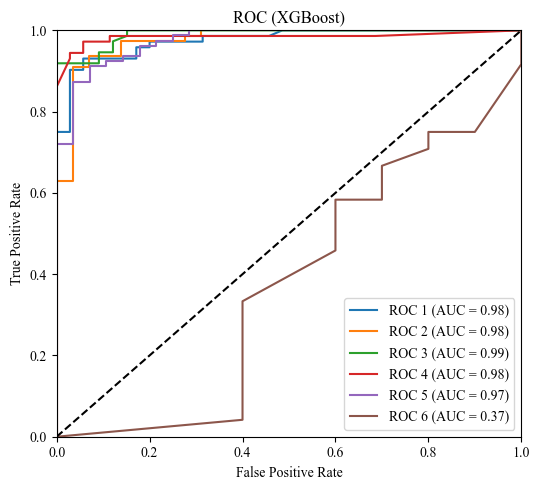

In [225]:
roc_aucs = []
for i in range(len(fprs)):
    roc_aucs.append(auc(fprs[i],tprs[i]))
fig = plt.figure(figsize = (5.5,5))
plt.title('ROC (XGBoost)')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'ROC %d (AUC = %0.2f)' % (i+1,roc_aucs[i]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
fig.savefig('roc2.svg')

In [238]:
valid_tb = pd.read_csv('./results/valid_all_features.csv')
valid_tb

,1D Gray Entropy,2D Gray Entropy,1D Hue Entropy,Color Richness,Relative Area,Horizontal Interval Metric,Vertical Interval Metric,Dominant Color X,Dominant Color Y,Dominant Color Z,label
0,1.057765,2.355009,2.984306,4.0,0.603691,0.002855,0.004579,-0.000000,0.000000,0.996078,1
1,3.190651,6.889010,4.135668,10.0,0.960619,0.001777,0.002574,0.000000,0.000000,0.988235,1
2,2.765383,6.024832,4.157235,7.0,0.938517,0.002572,0.002980,0.006573,0.004107,0.988235,1
3,2.217748,5.533011,4.632747,5.0,0.695489,0.001402,0.001468,-0.000000,0.000000,0.988235,1
4,2.423091,5.948474,4.300436,7.0,0.745724,0.001381,0.001389,0.002386,0.003054,0.988235,1
5,2.209020,5.404380,4.017312,5.0,0.851555,0.000883,0.001061,0.000000,0.000000,0.992157,1
6,2.673678,6.044106,2.846033,7.0,0.647294,0.002477,0.002281,0.012357,0.014726,0.980392,1
7,2.744171,6.551896,2.198130,4.0,0.901267,0.000720,0.001217,0.002386,0.003054,0.988235,1
8,2.273922,5.194957,3.323777,3.0,0.899065,0.002807,0.003555,0.002603,0.002891,0.992157,1
9,2.263381,5.180726,2.272553,4.0,0.899065,0.002778,0.003407,0.002603,0.002891,0.992157,1


In [239]:
dtrain = xgb.DMatrix(tb.iloc[:,:-1],tb.iloc[:,-1])
dvalid = xgb.DMatrix(valid_tb.iloc[:,:-1],valid_tb.iloc[:,-1])

param = {'max_depth':5, 'eta':0.1,'objective':'binary:logistic'}
tree = xgb.train(param, dtrain, num_boost_round=20)
valid_pred = tree.predict(dvalid)
fpr, tpr, thresholds = roc_curve(valid_tb.iloc[:,-1],valid_pred, pos_label=1)
for i in range(len(valid_pred)):
    if valid_pred[i] > 0.5:
         valid_pred[i]=1
    else:
        valid_pred[i]=0
print(valid_pred)
print(accuracy_score(valid_tb.iloc[:,-1],valid_pred), precision_score(valid_tb.iloc[:,-1], valid_pred), recall_score(valid_tb.iloc[:,-1], valid_pred), f1_score(valid_tb.iloc[:,-1], valid_pred), auc(fpr,tpr))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.7058823529411765 0.7058823529411765 1.0 0.8275862068965517 0.3729166666666667


In [258]:
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(tb.iloc[:,:-1])
expected_values = explainer.expected_value
np.save('./results/xgb_shap.npy', shap_values)
np.save('./results/xgb_shap_exp.npy', expected_values)

In [264]:
xgb_shap_values = np.load('./results/xgb_shap.npy', allow_pickle=True)
xgb_expected_values = np.load('./results/xgb_shap_exp.npy', allow_pickle=True)
svm_shap_values = np.load('./results/svm_shap.npy', allow_pickle=True)
svm_expected_values = np.load('./results/svm_shap_exp.npy', allow_pickle=True)